In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

spark = SparkSession.builder.appName('unsupervised').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '8g'), ('spark.app.name', 'Spark Updated Conf'),\
                                        ('spark.executor.cores', '8'), ('spark.cores.max', '8'), ('spark.driver.memory','8g')])

spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [2]:
import geopy
import dbscan

In [3]:
# read in rideshare data for all years, concatenate, create appropriate partitioning
# we are dropping 2020 because covid will affect the performance of our model

df_2018 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_time_rides_2018.csv", inferSchema=True, header=True)
df_2019 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_time_rides_2019.csv", inferSchema=True, header=True)
df_2021 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_time_rides_2021.csv", inferSchema=True, header=True)
df_2022 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_time_rides_2022.csv", inferSchema=True, header=True)
df_2023 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_time_rides_2023.csv", inferSchema=True, header=True)

# dropping new columns in 2023
df_2023 = df_2023.drop('Shared Trip Match','Percent Time Chicago','Percent Distance Chicago')

before = df_2018.union(df_2019)
after = df_2021.union(df_2022)


In [4]:
before.show(1)

+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----+------------+-------------+------------+-------------+-----+------------+----+---+
|                  ID|    start_timestamp|      end_timestamp|seconds|miles|pickup_tract|dropoff_tract|pickup_area|dropoff_area|Fare|Tip|total|  pickup_lat|   pickup_lon| dropoff_lat|  dropoff_lon|month|day_of_month|hour|day|
+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----+------------+-------------+------------+-------------+-----+------------+----+---+
|e516d63949ba04900...|2018-11-22 22:15:00|2018-11-22 22:15:00|    194|  0.7|        null|         null|         41|          41| 2.5|  5| 10.0|41.794090253|-87.592310855|41.794090253|-87.592310855|   11|          22|  22|  5|
+--------------------+-------------------+-------------------+-------+-----+------------+-------

In [5]:
after.show(1)

+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----------------+------------+-------------+------------+-------------+-----+------------+----+---+
|                  ID|    start_timestamp|      end_timestamp|seconds|miles|pickup_tract|dropoff_tract|pickup_area|dropoff_area|Fare|Tip|            total|  pickup_lat|   pickup_lon| dropoff_lat|  dropoff_lon|month|day_of_month|hour|day|
+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----------------+------------+-------------+------------+-------------+-----+------------+----+---+
|fd77b136fa1d4df45...|2021-11-16 17:45:00|2021-11-16 17:45:00|    247|  0.8|        null|         null|         41|          41| 5.0|  0|7.359999999999999|41.794090253|-87.592310855|41.794090253|-87.592310855|   11|          16|  17|  3|
+--------------------+-------------------+------

In [6]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)


In [7]:
before.rdd.getNumPartitions()
displaypartitions(before)

Partitions: 16


+-----------+-----+
|partitionId|count|
+-----------+-----+
|          7| 3242|
|          6| 3731|
|          5| 3982|
|          4| 4298|
|          3| 4702|
|          2| 7344|
|          1| 9349|
|          0|10993|
|         15|12512|
|         14|16357|
|         13|18177|
|         12|20071|
|         11|20717|
|         10|33168|
|          8|38440|
|          9|39548|
+-----------+-----+



In [8]:
after.rdd.getNumPartitions()
displaypartitions(after)

Partitions: 21


+-----------+-----+
|partitionId|count|
+-----------+-----+
|         15|   82|
|         14|  212|
|         13|  282|
|         12|  434|
|         11|  554|
|         10|  726|
|          9|  967|
|          8| 1164|
|          7| 1944|
|          6| 2307|
|          5| 3238|
|          4| 5508|
|         31| 5795|
|          3| 5853|
|          2| 9015|
|         30|10970|
|         29|11178|
|          1|11261|
|         28|11462|
|         27|11731|
|          0|11912|
+-----------+-----+
only showing top 21 rows



In [15]:
before = before.repartition(50)
after = after.repartition(50)

# Feature Engineering

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from sklearn import metrics
from pyspark.sql.functions import col, radians, acos, sin, cos, lit
import time
from pyspark.ml.feature import VectorAssembler
import geopandas as gpd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

In [10]:
# combining pickup and dropoff location latitudes and longitudes for before and after lyft program data

pickAssembler = VectorAssembler(inputCols=["pickup_lat", "pickup_lon"], outputCol="pickup_features")
dropAssembler = VectorAssembler(inputCols=["dropoff_lat", "dropoff_lon"], outputCol="dropoff_features")

# Modeling

In [11]:
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col


# KMeans for pickup features
kmeans_pickup = KMeans(seed=1, featuresCol='pickup_features', predictionCol='pickup_cluster')

# KMeans for dropoff features
kmeans_dropoff = KMeans(seed=1, featuresCol='dropoff_features', predictionCol='dropoff_cluster')


In [13]:
# Create ML pipeline

pipeline_p = Pipeline(stages=[pickAssembler, kmeans_pickup])
pipeline_d = Pipeline(stages=[dropAssembler, kmeans_dropoff])

In [14]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import ClusteringEvaluator


paramGrid = ParamGridBuilder() \
    .addGrid(kmeans_pickup.k, [3, 5, 7, 8, 10, 12, 13, 15]) \
    .addGrid(kmeans_dropoff.k, [3, 5, 7, 8, 10, 12, 13, 15]) \
    .build()

# Set up the evaluator
evaluator_p = ClusteringEvaluator()\
                          .setFeaturesCol('pickup_features')\
                          .setPredictionCol('pickup_cluster')

evaluator_d = ClusteringEvaluator()\
                          .setFeaturesCol('dropoff_features')\
                          .setPredictionCol('dropoff_cluster')
# Set up CrossValidator
crossval_p = CrossValidator(estimator=pipeline_p,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_p,
                          numFolds=3)\
                          

crossval_d = CrossValidator(estimator=pipeline_d,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_d,
                          numFolds=3)


In [15]:
# Fit the model
cvModel_p = crossval_p.fit(before) 
cvModel_d = crossval_d.fit(before) 

# Get the best model from the cross-validation
bestPickupModel = cvModel_p.bestModel
bestDropoffModel = cvModel_d.bestModel


bestKMeansPickup = bestPickupModel.stages[1]  
bestKMeansDropoff = bestDropoffModel.stages[1]  


23/11/25 05:04:38 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/11/25 05:04:38 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [16]:
# Applying the best model on the before data

before = pickAssembler.transform(before)
before = bestKMeansPickup.transform(before)


before = dropAssembler.transform(before)
before = bestKMeansDropoff.transform(before)

before.printSchema()

root
 |-- ID: string (nullable = true)
 |-- start_timestamp: timestamp (nullable = true)
 |-- end_timestamp: timestamp (nullable = true)
 |-- seconds: integer (nullable = true)
 |-- miles: double (nullable = true)
 |-- pickup_tract: long (nullable = true)
 |-- dropoff_tract: long (nullable = true)
 |-- pickup_area: integer (nullable = true)
 |-- dropoff_area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tip: integer (nullable = true)
 |-- total: double (nullable = true)
 |-- pickup_lat: double (nullable = true)
 |-- pickup_lon: double (nullable = true)
 |-- dropoff_lat: double (nullable = true)
 |-- dropoff_lon: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- pickup_features: vector (nullable = true)
 |-- pickup_cluster: integer (nullable = false)
 |-- dropoff_features: vector (nullable = true)
 |-- dropoff_cluster: integer (nul

In [17]:
# Fit the model for after data
cvModel_p = crossval_p.fit(after) 
cvModel_d = crossval_d.fit(after) 

# Get the best model from the cross-validation
bestPickupModel = cvModel_p.bestModel
bestDropoffModel = cvModel_d.bestModel


bestKMeansPickup = bestPickupModel.stages[1]  
bestKMeansDropoff = bestDropoffModel.stages[1] 

In [18]:
# Applying the best model on the after data

after = pickAssembler.transform(after)
after = bestKMeansPickup.transform(after)


after = dropAssembler.transform(after)
after = bestKMeansDropoff.transform(after)

after.printSchema()

root
 |-- ID: string (nullable = true)
 |-- start_timestamp: timestamp (nullable = true)
 |-- end_timestamp: timestamp (nullable = true)
 |-- seconds: integer (nullable = true)
 |-- miles: double (nullable = true)
 |-- pickup_tract: long (nullable = true)
 |-- dropoff_tract: long (nullable = true)
 |-- pickup_area: integer (nullable = true)
 |-- dropoff_area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tip: integer (nullable = true)
 |-- total: double (nullable = true)
 |-- pickup_lat: double (nullable = true)
 |-- pickup_lon: double (nullable = true)
 |-- dropoff_lat: double (nullable = true)
 |-- dropoff_lon: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- pickup_features: vector (nullable = true)
 |-- pickup_cluster: integer (nullable = false)
 |-- dropoff_features: vector (nullable = true)
 |-- dropoff_cluster: integer (nul

In [19]:
after.printSchema()

root
 |-- ID: string (nullable = true)
 |-- start_timestamp: timestamp (nullable = true)
 |-- end_timestamp: timestamp (nullable = true)
 |-- seconds: integer (nullable = true)
 |-- miles: double (nullable = true)
 |-- pickup_tract: long (nullable = true)
 |-- dropoff_tract: long (nullable = true)
 |-- pickup_area: integer (nullable = true)
 |-- dropoff_area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tip: integer (nullable = true)
 |-- total: double (nullable = true)
 |-- pickup_lat: double (nullable = true)
 |-- pickup_lon: double (nullable = true)
 |-- dropoff_lat: double (nullable = true)
 |-- dropoff_lon: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- pickup_features: vector (nullable = true)
 |-- pickup_cluster: integer (nullable = false)
 |-- dropoff_features: vector (nullable = true)
 |-- dropoff_cluster: integer (nul

In [20]:
after.select('pickup_cluster', 'dropoff_cluster').show(5)

+--------------+---------------+
|pickup_cluster|dropoff_cluster|
+--------------+---------------+
|             1|              3|
|             6|             11|
|             5|             13|
|             5|             12|
|             5|              1|
+--------------+---------------+
only showing top 5 rows



In [21]:
before_pd = before.select('pickup_lon','pickup_lat', 'pickup_cluster').toPandas()


In [22]:
before_pd['pickup_cluster'].unique()

array([10, 14,  1,  3,  9, 11,  6,  8, 13, 12,  2,  5,  4,  0,  7],
      dtype=int32)

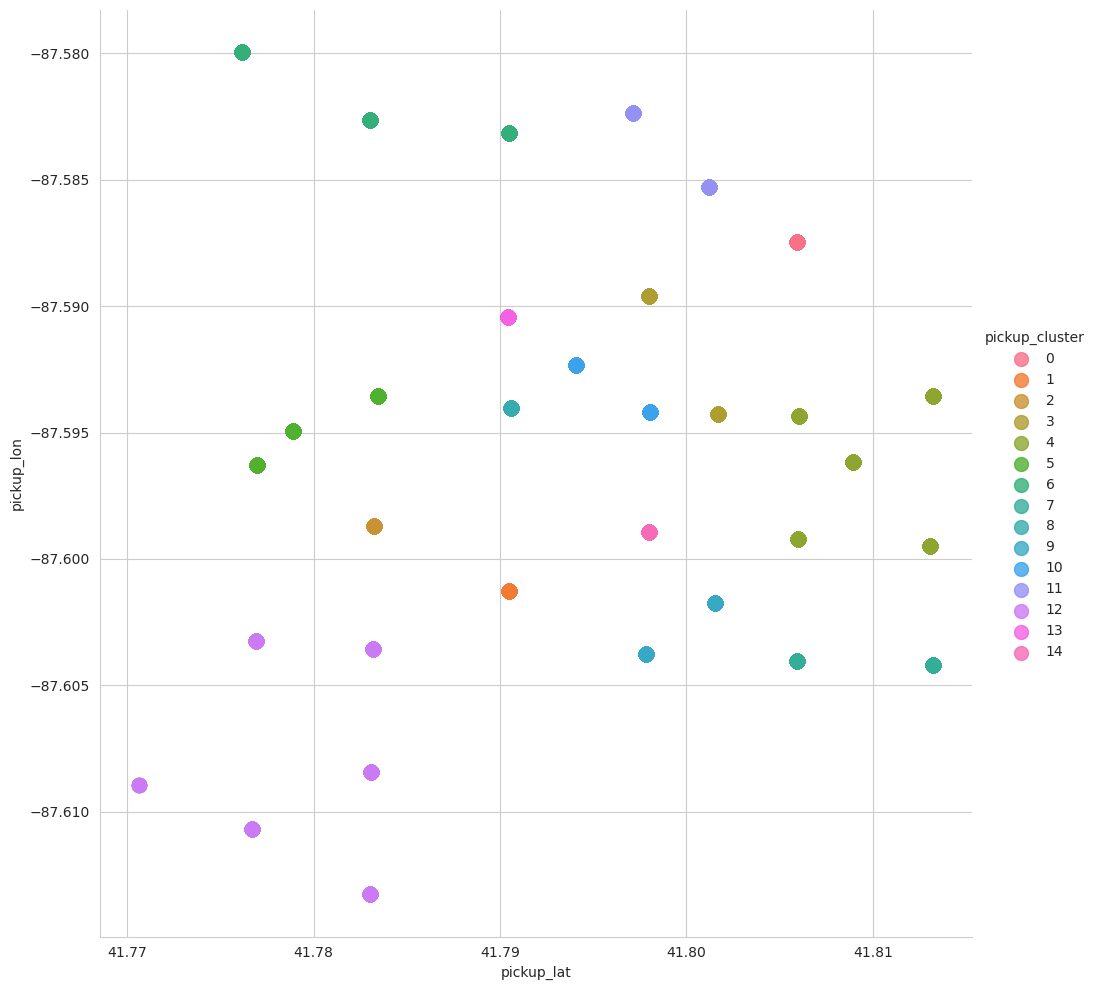

In [23]:
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns

sns.set_style("whitegrid")
sns.lmplot(x="pickup_lat", y="pickup_lon",data = before_pd[before_pd['pickup_lat']!=0.0],fit_reg=False,hue='pickup_cluster',height=10,scatter_kws={"s":100})


In [24]:
after_pd = after.select('pickup_lon','pickup_lat', 'pickup_cluster').toPandas()
after_pd['pickup_cluster'].unique()

array([ 1,  6,  5, 11, 14,  4, 12,  3,  9,  2, 10, 13,  8,  0,  7],
      dtype=int32)

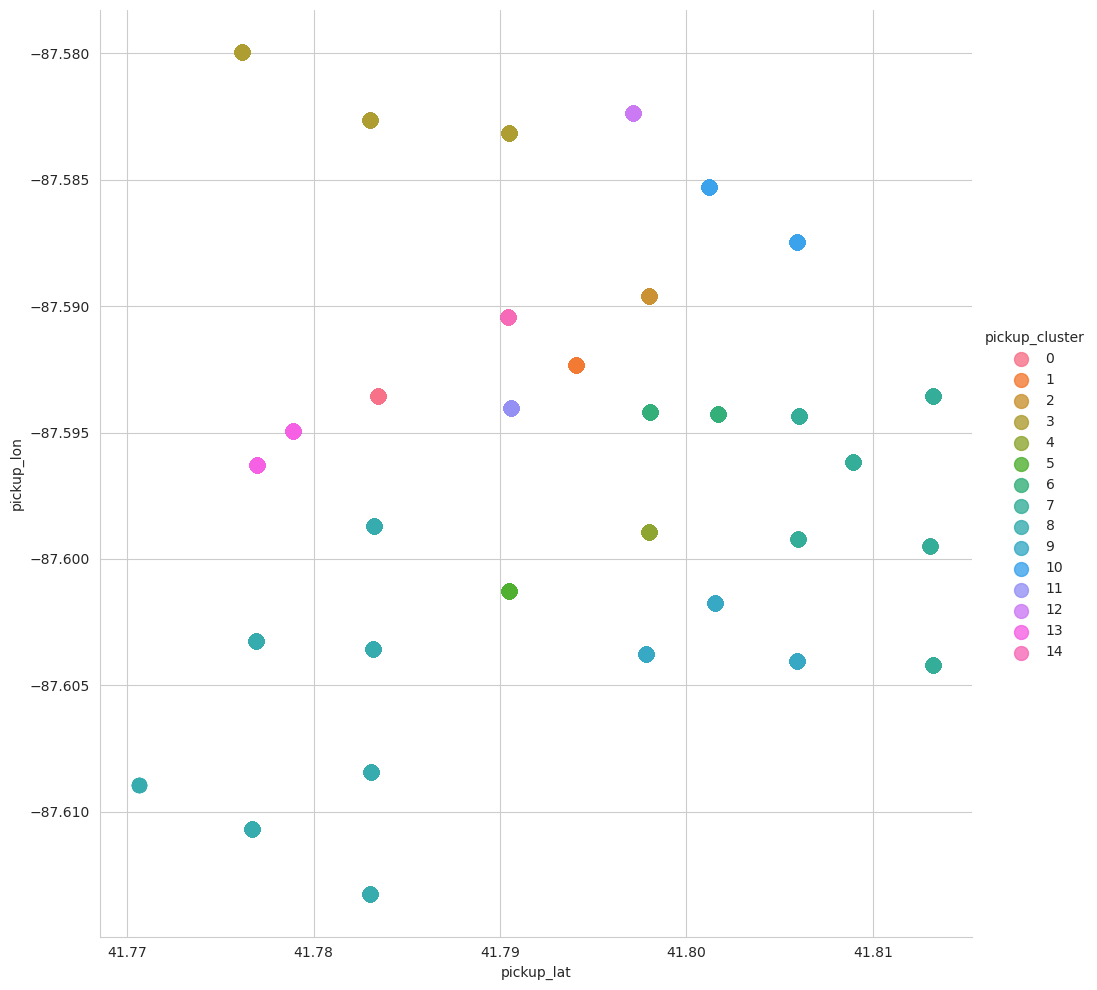

In [25]:
sns.set_style("whitegrid")
sns.lmplot(x="pickup_lat", y="pickup_lon",data = after_pd[after_pd['pickup_lat']!=0.0],fit_reg=False,hue='pickup_cluster',height=10,scatter_kws={"s":100})


In [30]:
from geopy.distance import great_circle
from shapely.geometry import Point, MultiPoint
import pandas as pd


# Define the get_centermost_point function
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

before_pickup_centers = before_pd.groupby('pickup_cluster')\
                                 .apply(lambda cluster: get_centermost_point(list(zip(cluster['pickup_lon'], cluster['pickup_lat']))))

before_pickup_centers = pd.DataFrame(before_pickup_centers.tolist(), columns=['center_lon', 'center_lat'])


after_pickup_centers = before_pd.groupby('pickup_cluster')\
                                 .apply(lambda cluster: get_centermost_point(list(zip(cluster['pickup_lon'], cluster['pickup_lat']))))

after_pickup_centers = pd.DataFrame(after_pickup_centers.tolist(), columns=['center_lon', 'center_lat'])


print(before_pickup_centers)
print(after_pickup_centers)


    center_lon  center_lat
0   -87.587479   41.805912
1   -87.601285   41.790469
2   -87.598697   41.783225
3   -87.589607   41.797965
4   -87.596183   41.808916
5   -87.594925   41.778877
6   -87.582630   41.783034
7   -87.604209   41.813201
8   -87.594015   41.790567
9   -87.603746   41.797827
10  -87.592311   41.794090
11  -87.585303   41.801227
12  -87.603559   41.783171
13  -87.590431   41.790448
14  -87.598945   41.797971
    center_lon  center_lat
0   -87.587479   41.805912
1   -87.601285   41.790469
2   -87.598697   41.783225
3   -87.589607   41.797965
4   -87.596183   41.808916
5   -87.594925   41.778877
6   -87.582630   41.783034
7   -87.604209   41.813201
8   -87.594015   41.790567
9   -87.603746   41.797827
10  -87.592311   41.794090
11  -87.585303   41.801227
12  -87.603559   41.783171
13  -87.590431   41.790448
14  -87.598945   41.797971


In [35]:
before_drop = before.select('dropoff_lon','dropoff_lat', 'dropoff_cluster').toPandas()
after_drop = after.select('dropoff_lon','dropoff_lat', 'dropoff_cluster').toPandas()

In [37]:
before_dropoff_centers = before_drop.groupby('dropoff_cluster')\
                                 .apply(lambda cluster: get_centermost_point(list(zip(cluster['dropoff_lon'], cluster['dropoff_lat']))))

before_dropoff_centers = pd.DataFrame(before_dropoff_centers.tolist(), columns=['center_lon', 'center_lat'])


after_dropoff_centers = after_drop.groupby('dropoff_cluster')\
                                 .apply(lambda cluster: get_centermost_point(list(zip(cluster['dropoff_lon'], cluster['dropoff_lat']))))

after_dropoff_centers = pd.DataFrame(after_dropoff_centers.tolist(), columns=['center_lon', 'center_lat'])


print(before_dropoff_centers)
print(after_dropoff_centers)

    center_lon  center_lat
0   -87.589607   41.797965
1   -87.582366   41.797153
2   -87.603746   41.797827
3   -87.594925   41.778877
4   -87.596183   41.808916
5   -87.601285   41.790469
6   -87.587479   41.805912
7   -87.608427   41.783101
8   -87.598945   41.797971
9   -87.594015   41.790567
10  -87.582630   41.783034
11  -87.592311   41.794090
12  -87.590431   41.790448
13  -87.585303   41.801227
14  -87.598697   41.783225
    center_lon  center_lat
0   -87.587479   41.805912
1   -87.601285   41.790469
2   -87.594925   41.778877
3   -87.592311   41.794090
4   -87.603746   41.797827
5   -87.583144   41.790506
6   -87.598697   41.783225
7   -87.579948   41.776164
8   -87.582366   41.797153
9   -87.594015   41.790567
10  -87.585303   41.801227
11  -87.594266   41.801671
12  -87.589607   41.797965
13  -87.590431   41.790448
14  -87.596183   41.808916


In [ ]:
from geopy.geocoders import GoogleV3

# Replace 'your_api_key' with your actual Google Maps API key
api_key = 'your_api_key'
geolocator = GoogleV3(api_key=api_key)

def get_address(lat, lon):
    location = geolocator.reverse((lat, lon), language='en')
    return location.address

# Example usage
latitude = 37.7749  # Replace with your latitude
longitude = -122.4194  # Replace with your longitude

address = get_address(latitude, longitude)
print("Address:", address)


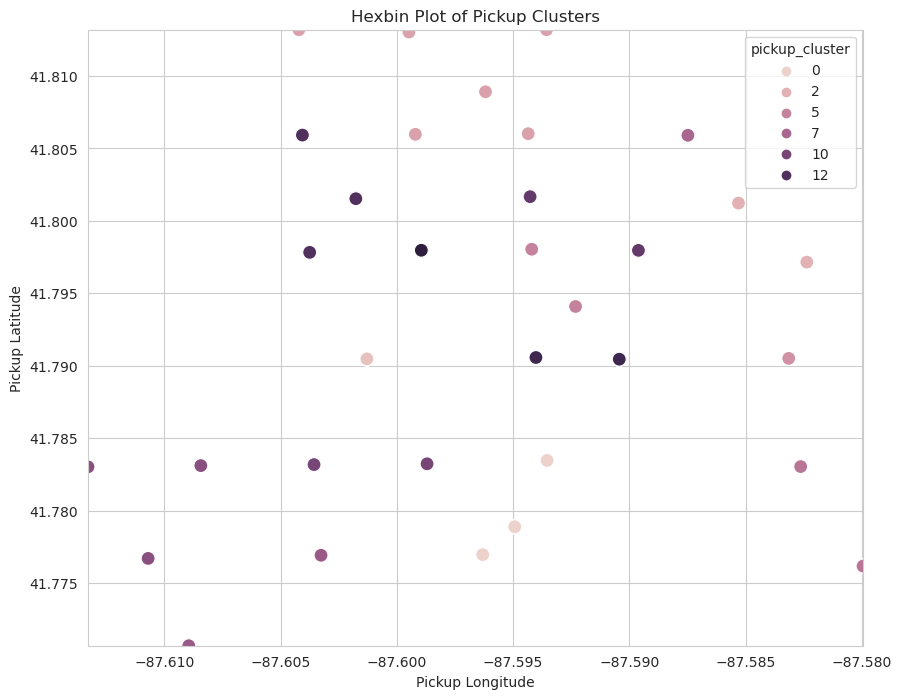

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
sns.scatterplot(x="pickup_lon", y="pickup_lat", data=pd_df[pd_df['pickup_lat'] != 0.0], hue='pickup_cluster', s=100)
plt.xlim( -87.6132781783, -87.5799482481)
plt.ylim(41.7706622278, 41.8132012947)
plt.xlabel('Pickup Longitude')
plt.ylabel('Pickup Latitude')
plt.title('Hexbin Plot of Pickup Clusters')
plt.show()



In [83]:
print(before_pd['pickup_lat'].max())
before_pd['pickup_lat'].min()

41.8132012947


41.7706622278

In [84]:
print(before_pd['pickup_lon'].max())
before_pd['pickup_lon'].min()

-87.5799482481


-87.6132781783

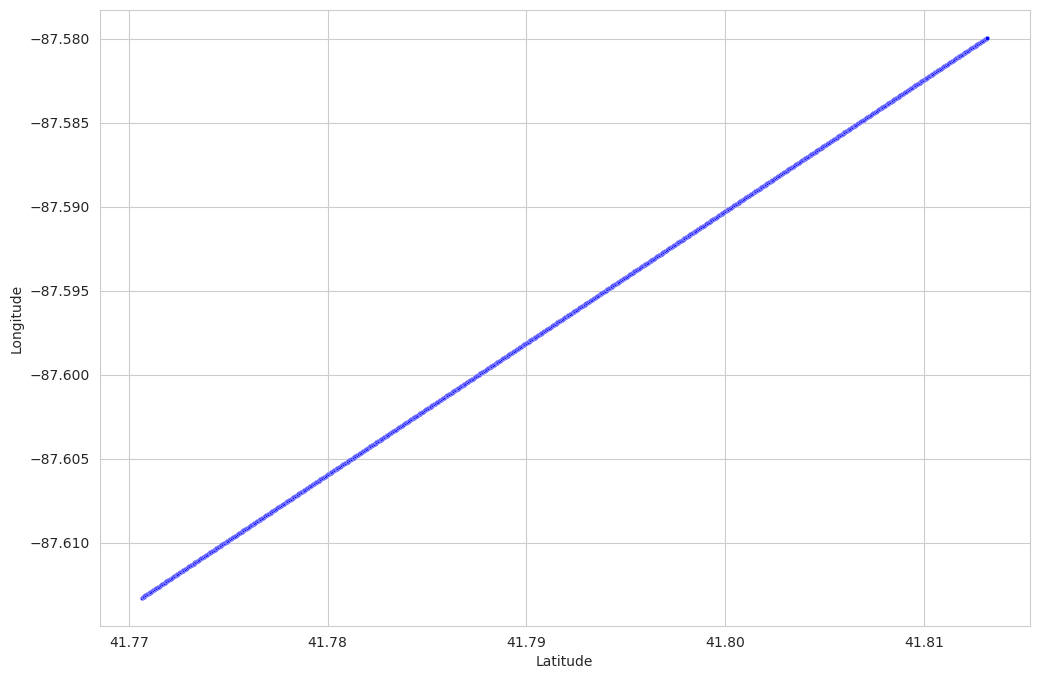

In [88]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming pd_df is your original DataFrame

# Set latitude and longitude limits
min_lat, max_lat = 41.7706622278, 41.8132012947
min_lon, max_lon = -87.6132781783, -87.5799482481

# Generate more granular points within the specified range
num_points = 1000
granular_lat = np.linspace(min_lat, max_lat, num_points)
granular_lon = np.linspace(min_lon, max_lon, num_points)

# Create a DataFrame with granular data points
granular_df = pd.DataFrame({'pickup_lat': granular_lat, 'pickup_lon': granular_lon})

# Plot the granular scatter plot
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
plot = sns.scatterplot(x="pickup_lat", y="pickup_lon", data=granular_df, s=10, color='blue')

# Set x-axis and y-axis labels
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()


# this piece of code was depreciated 

In [5]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

df_all.rdd.getNumPartitions()
displaypartitions(df_all)

Partitions: 534


+-----------+------+
|partitionId| count|
+-----------+------+
|         33|152646|
|        233|328837|
|        232|328975|
|        231|329131|
|        230|329163|
|        229|329209|
|        227|329245|
|        225|329263|
|        228|329263|
|        224|329311|
|        226|329315|
|        222|329332|
|        223|329344|
|        221|329373|
|        218|329389|
|        219|329390|
|        217|329399|
|        215|329410|
|        216|329410|
|        214|329418|
|        220|329427|
|        213|329428|
|        210|329461|
|        212|329481|
|        211|329505|
|        207|329507|
|        208|329513|
|        209|329519|
|        206|329523|
|        204|329533|
|        203|329555|
|        205|329574|
|        201|329587|
|        202|329591|
|        198|329607|
|        200|329623|
|        196|329624|
|        199|329630|
|        197|329633|
|        195|329646|
|        192|329654|
|        194|329673|
|        193|329678|
|        184|329704|
|        191|

In [4]:
# repartitioning to 600 partitions
df_all = df_all.repartition(600).cache()
#displaypartitions(df_all)

**Feature Engineering**


In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp

df_all = df_all.withColumn("start_timestamp", unix_timestamp("start_timestamp"))
df_all = df_all.withColumn("end_timestamp", unix_timestamp("end_timestamp"))

# Calculate trip duration in seconds
df_all = df_all.withColumn("trip_duration", col("end_timestamp") - col("start_timestamp"))

# Convert seconds to minutes
df_all = df_all.withColumn("trip_duration", col("trip_duration") / 60)

df_all.select('trip_duration').show()


+-------------+
|trip_duration|
+-------------+
|         30.0|
|         30.0|
|         30.0|
|          0.0|
|         30.0|
|         15.0|
|         15.0|
|         15.0|
|         15.0|
|         15.0|
|         15.0|
|         15.0|
|         60.0|
|         15.0|
|         45.0|
|         15.0|
|          0.0|
|         30.0|
|         15.0|
|         45.0|
+-------------+
only showing top 20 rows



In [4]:
from pyspark.sql.functions import col, unix_timestamp

df_2018 = df_2018.withColumn("start_timestamp", unix_timestamp("start_timestamp"))
df_2018 = df_2018.withColumn("end_timestamp", unix_timestamp("end_timestamp"))

# Calculate trip duration in seconds
df_2018 = df_2018.withColumn("trip_duration", col("end_timestamp") - col("start_timestamp"))

# Convert seconds to minutes
df_2018 = df_2018.withColumn("trip_duration", col("trip_duration") / 60)

df_2018.select('trip_duration').show()

+-------------+
|trip_duration|
+-------------+
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|         15.0|
|         15.0|
|          0.0|
|          0.0|
|         15.0|
|          0.0|
|          0.0|
|          0.0|
+-------------+
only showing top 20 rows



In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from sklearn import metrics
from pyspark.sql.functions import col, radians, acos, sin, cos, lit
import time
from pyspark.ml.feature import VectorAssembler


In [7]:
df_all.printSchema()

root
 |-- ID: string (nullable = true)
 |-- start_timestamp: long (nullable = true)
 |-- end_timestamp: long (nullable = true)
 |-- seconds: integer (nullable = true)
 |-- miles: double (nullable = true)
 |-- pickup_tract: long (nullable = true)
 |-- dropoff_tract: long (nullable = true)
 |-- pickup_area: integer (nullable = true)
 |-- dropoff_area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tip: integer (nullable = true)
 |-- total: double (nullable = true)
 |-- pickup_lat: double (nullable = true)
 |-- pickup_lon: double (nullable = true)
 |-- dropoff_lat: double (nullable = true)
 |-- dropoff_lon: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- trip_duration: double (nullable = true)



In [107]:
pdf = before.select('ID', 'pickup_lat','pickup_lon', 'dropoff_lat', 'dropoff_lon').toPandas()


In [110]:
# Earth's radius in kilometers
rad_in_kms = 6371
len(pdf)

246631

In [ ]:
# Fit DBSCAN model for pickup location using scikit-learn
epsilon_pickup = 0.5 / rad_in_kms  # Earth's radius in kilometers
dbscan_pickup = DBSCAN(eps=0.006, min_samples=10, algorithm='ball_tree', metric='haversine')
pickup_features = np.array(pdf[["pickup_lon", "pickup_lat"]])
pdf["pickup_prediction"] = dbscan_pickup.fit_predict(pickup_features)

# Filter out noise points for pickup location (prediction == -1)
#pdf = pdf[pdf["pickup_prediction"] != -1]


In [62]:
# Fit DBSCAN model for dropoff location using scikit-learn
epsilon_dropoff = 1.5 / rad_in_kms  
dbscan_dropoff = DBSCAN(eps=0.03, min_samples=10, algorithm='ball_tree', metric='haversine')
dropoff_features = np.array(pdf[["dropoff_lon", "dropoff_lat"]])
pdf["dropoff_prediction"] = dbscan_dropoff.fit_predict(dropoff_features)

# Filter out noise points for dropoff location (prediction == -1)
#pdf = pdf[pdf["dropoff_prediction"] != -1]


In [80]:
len(pdf)

47641

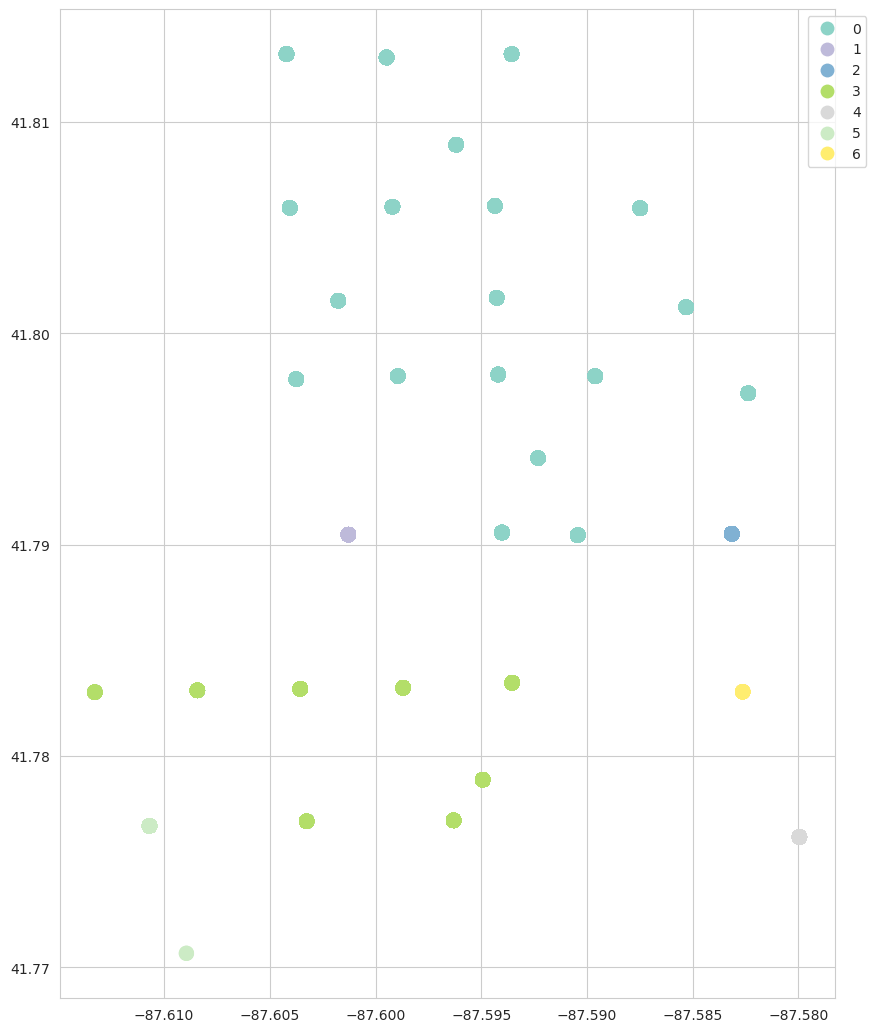

In [87]:
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(pdf['pickup_lon'], pdf['pickup_lat'])]
geo_df = gpd.GeoDataFrame(pdf, geometry=geometry)

# Plotting
fig, ax = plt.subplots(figsize=(10, 15))
geo_df.plot(ax=ax, markersize=100, column='pickup_prediction', cmap='Set3', categorical=True, legend=True)

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.05, 1))  # Adjust the values as needed

plt.show()


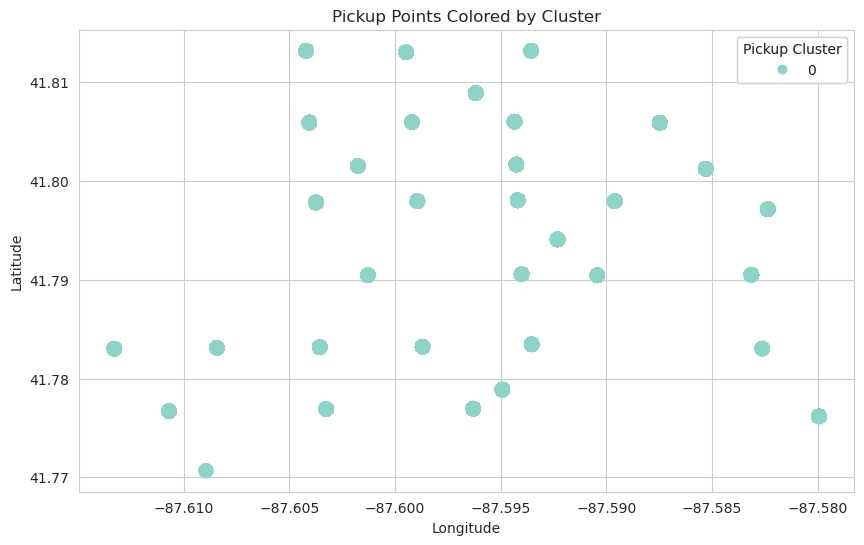

In [71]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'pd_df' with pickup cluster information
# You can replace 'pickup_longitude', 'pickup_latitude', and 'pickup_cluster' with your actual column names

plt.figure(figsize=(10, 6))

# Scatter plot colored by cluster
scatter = plt.scatter(pdf['pickup_lon'], pdf['pickup_lat'], c=pdf['pickup_prediction'], cmap='Set3', s=100)

# Add legend
legend = plt.legend(*scatter.legend_elements(), title='Pickup Cluster')
plt.gca().add_artist(legend)

plt.title('Pickup Points Colored by Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


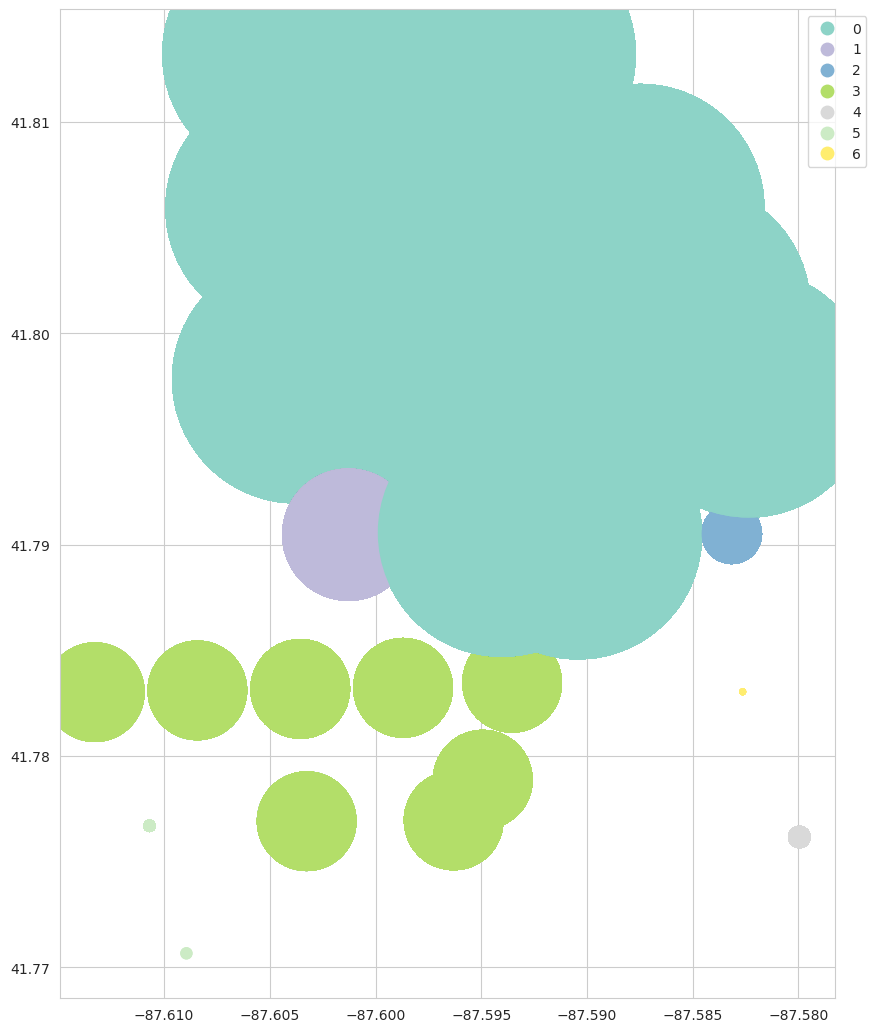

In [85]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Assuming 'pickup_prediction' is a categorical variable in your GeoDataFrame
pdf['pickup_prediction'] = pdf['pickup_prediction'].astype('category')

# Calculate the count of records for each category
category_counts = pdf['pickup_prediction'].value_counts()

# Create a dictionary mapping each category to its count
category_count_dict = dict(zip(category_counts.index, category_counts.values))

# Create a new column 'count' in the GeoDataFrame to store the count for each record's category
geo_df['count'] = geo_df['pickup_prediction'].map(category_count_dict)

# Plotting
fig, ax = plt.subplots(figsize=(10, 15))
geo_df.plot(ax=ax, markersize=geo_df['count'], column='pickup_prediction', cmap='Set3', categorical=True, legend=True)

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.05, 1))  # Adjust the values as needed

plt.show()

In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=15, seed=1) 
model = kmeans.fit(df_2018.select('features'))

### Vecorizing and getting pickup clusters
vecAssembler = VectorAssembler(inputCols=["pickup_latitude", "pickup_longitude"], outputCol="features")
new_df = vecAssembler.transform(df)
df = model.transform(new_df)

## assigniung prediction to pickup cluster
df = data1_df.withColumnRenamed('prediction', 'pickup_cluster')
df = data1_df.drop('features')

### Vecorizing and getting dropoff clusters
vecAssembler = VectorAssembler(inputCols=["dropoff_latitude", "dropoff_longitude"], outputCol="features")
new_df = vecAssembler.transform(df)
df = model.transform(new_df)

## assigniung prediction to dropoff cluster
df = data1_df.withColumnRenamed('prediction', 'dropoff_cluster')
df = data1_df.drop('features')

whether clusters have increased or decreased, distance between clusters, figure out the actual locations, put geo markers on map, closest centroid to key locations and how that changesyea

combine before and after

movement of centroids over the years

